# Interface Demonstration Notebook

A notebook to demonstrate an interface with some of the features of the Probability of Failure Model

Author: gavin.treseder@essentialenergy.com.au

In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import logging
logging.getLogger().setLevel(logging.INFO)

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import copy
import multiprocessing as mp

import dash
import dash_bootstrap_components as dbc
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State
import plotly.express as px
import plotly.graph_objects as go
from jupyter_dash import JupyterDash

from pof.loader.asset_model_loader import AssetModelLoader
from pof import Component, FailureMode
from pof.interface.layouts import *
from pof.interface.figures import update_condition_fig, update_cost_fig, update_pof_fig, make_inspection_interval_fig

In [2]:
comp = Component.demo()
fm = FailureMode.demo()

In [3]:
# Illyse -> this method loads the full file and takes a while
from config import config
config.set('DEFAULT', 'on_error_use_default', 'False')

filename = os.path.dirname(os.getcwd()) + r"\data\inputs\Asset Model - Demo.xlsx"

aml = AssetModelLoader(filename)
comp_data = aml.load()
comp = Component.from_dict(comp_data['pole'])

In [4]:
# Component layout
mcl = make_component_layout(comp)
mfml = make_failure_mode_layout(fm)

var_to_scale = cf.scaling

In [5]:
validate_layout(comp, mcl)

True

In [6]:
graph_limit =  dbc.InputGroup(
    [
        dbc.InputGroupAddon(
            [
                dbc.Checkbox(id='graph_y_limit_active', checked=True),
                
            ],
            addon_type="prepend"
        ),
        dbc.Label("Graph Y Limit"),
        dbc.Input(
            type="number",
            id= 'graph_y_limit',
            #value = ,
            debounce=True,
        ),
    ],
)

graph_inputs = [Input('graph_y_limit_active', 'checked'), Input('graph_y_limit', 'value')]

Change the looging level to critical to speed up execution

In [7]:
logging.getLogger().setLevel(logging.CRITICAL)

In [8]:
inline = True

# Build App
external_stylesheets = [dbc.themes.BOOTSTRAP]
if inline:
    app = JupyterDash(__name__, external_stylesheets=external_stylesheets)
else:
    app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

# Layout
app.layout = html.Div([
    html.Div(children='Test Output', id='test_output'),
    graph_limit,
    dbc.Row(
        [
            dbc.Col(dcc.Graph(id='pof-fig')),
            dbc.Col(dcc.Graph(id='insp_interval-fig')),
        ]
    ),
        dbc.Row(
        [
            dbc.Col(dcc.Graph(id='cond-fig')),
            dbc.Col(dcc.Graph(id="cost-fig"))
        ]
    ),
    mcl,
])


ms_fig_update = comp.get_dash_ids()
param_inputs = [Input(dash_id,"checked") if 'active' in dash_id else Input(dash_id,"value") for dash_id in ms_fig_update]

collapse_ids = comp.get_objects()

@app.callback(
    [Output(f"{prefix}-collapse", "is_open") for prefix in collapse_ids],
    [Input(f"{prefix}-collapse-button", "n_clicks") for prefix in collapse_ids],
    [State(f"{prefix}-collapse", "is_open") for prefix in collapse_ids],
)
def toggle_collapses(*args):
    ctx = dash.callback_context

    state_id = ""
    collapse_id = ctx.triggered[0]['prop_id'].split('.')[0].replace('-collapse-button','')
    if collapse_id in collapse_ids: #TODO change to is not None

        state_id = collapse_id + '-collapse.is_open'
        ctx.states[state_id] = not ctx.states[state_id]

    is_open = tuple(ctx.states.values())

    return is_open

@app.callback(
    [Output("cost-fig", "figure"),
    Output("pof-fig", "figure"),
    Output("cond-fig", "figure")], 
    graph_inputs + param_inputs
)
def update_maintenance_strategy(graph_y_limit_active, graph_y_limit, *args):

    # Check the parameters that changed
    ctx = dash.callback_context

    # If any parameters have changed update the objecte
    if ctx.triggered:
        dash_id = ctx.triggered[0]['prop_id'].split('.')[0]
        value = ctx.triggered[0]['value']

        # Scale the value if req
        value = value / var_to_scale.get(dash_id.split('-')[-1], 1)

        # update the model
        comp.update(dash_id, value)

    # Simulate an outcome
    local = copy.deepcopy(comp)
    local.mc_timeline(t_end=200, n_iterations=100)

    #if graph_y_limit_active:
    #    fig.update_yaxes(range=[0, graph_y_limit])

    cost_fig = update_cost_fig(local)
    pof_fig = update_pof_fig(local)
    cond_fig = update_condition_fig(local)

    return cost_fig, pof_fig, cond_fig


# Illyse -> this method calculates the opitmum inspection interval and is a little bit slower
@app.callback(
    Output("insp_interval-fig", "figure"), 
    param_inputs + [Input('cost-fig', 'value')]
)
def update_insp_interval(*args):

    # Check the parameters that changed
    ctx = dash.callback_context

    # If any parameters have changed update the objecte
    if ctx.triggered:
        dash_id = ctx.triggered[0]['prop_id'].split('.')[0]
        value = ctx.triggered[0]['value']

        # Scale the value if req
        value = value / var_to_scale.get(dash_id.split('-')[-1], 1)

        # update the model
        copm.update(dash_id, value)

    # Simulate an outcome

    local = copy.deepcopy(comp)

    #if graph_y_limit_active:
    #    fig.update_yaxes(range=[0, graph_y_limit])

    insp_interval_fig = make_inspection_interval_fig(local, t_min=0, t_max=10, step=1, n_iterations = 10)

    return insp_interval_fig

i = [1]

@app.callback(
    Output("test_output", "children"),
    [Input('cost-fig', 'value')]
)
def test(task_value, idx = i):
    # Check the parameters that changed
    ctx = dash.callback_context
    dash_id = ctx.triggered[0]['prop_id'].split('.')[0]
    value = ctx.triggered[0]['value']
    
    idx[0] = idx[0] + 1

    return "value" + str(value) + idx



#Execute
if inline:
    app.run_server(mode='inline', debug=True)
else:
    app.run_server(debug=False) # visit http://127.0.0.1:8050/ in your web browser.


In [14]:
comp.fm

{'termites': <pof.failure_mode.FailureMode at 0x12be5bb9f40>,
 'fungal decay - external': <pof.failure_mode.FailureMode at 0x12bfb497f70>,
 'fungal decay - internal': <pof.failure_mode.FailureMode at 0x12bfb497400>,
 'lightning': <pof.failure_mode.FailureMode at 0x12bfb4c4250>,
 'fire_damage': <pof.failure_mode.FailureMode at 0x12bfb4c4550>,
 'impact': <pof.failure_mode.FailureMode at 0x12bfb4c4850>,
 'weathering': <pof.failure_mode.FailureMode at 0x12bfb4c4ac0>,
 'fm': <pof.failure_mode.FailureMode at 0x12b82681bb0>}

In [17]:
for fm_name, fm in comp.fm.items():
    print(fm_name)
    for dist in fm.dists:
        print(dist)

termites
untreated
init
fungal decay - external
untreated
init
fungal decay - internal
untreated
init
lightning
untreated
init
fire_damage
untreated
init
impact
untreated
init
weathering
untreated
init
fm


In [23]:
comp.fm['fm'].__dict__

{'_name': 'fm',
 'active': True,
 '_pf_curve': 'step',
 '_pf_interval': 0,
 'pf_std': 0,
 'dists': {},
 'indicators': {'fm': ConditionIndicator(name='fm', pf_curve='step', pf_interval=0, pf_std=0, perfect=False, failed=True, decreasing=False, threshold_detection=False, threshold_failure=True, initial=False)},
 'conditions': {},
 'consequences': {},
 'consequence': <pof.consequence.Consequence at 0x1ca5005bd60>,
 'tasks': {},
 'init_states': {'initiation': False, 'detection': False, 'failure': False},
 'states': {'initiation': False, 'detection': False, 'failure': False},
 'timeline': {},
 '_timelines': {},
 '_sim_counter': 0}

,wall_thickness
name,wall_thickness
pf_curve,linear
pf_std,1


In [18]:
cond_name = 'wall_thickness'

if cond_name is None:
    pf_interval =  fm.pf_interval
elif cond_name is not None and cond_name in fm.conditions:
    pf_interval = fm.conditions[cond_name].get("pf_interval", fm.pf_interval)
    
    if pf_interval is None:
        pf_interval = fm.pf_interval

else:
    pf_interval = None

pf_interval

nan

In [12]:
comp.fm['slow_aging'].conditions['slow_degrading'].get(
                        "pf_interval", comp.fm['slow_aging'].pf_interval
                    )

20

In [11]:
comp.fm['slow_aging'].indicators['slow_degrading'].pf_interval=None

In [15]:

comp.mc_timeline(t_end=200, n_iterations=100)

100%|██████████| 100/100 [00:35<00:00,  2.79it/s]


In [22]:
comp.indicator['simple_safety_factor']
comp.indicator['wall_thickness'].get_timeline()

array([125., 125., 125., 125., 125., 125., 125., 125., 125., 125., 125.,
       125., 125., 125., 125., 125., 125., 125., 125., 125., 125., 125.,
       125., 125., 125., 125., 125., 125., 125., 125., 125., 125., 125.,
       125., 125., 125., 125., 125., 125., 125., 125., 125.,   0., 125.,
       125., 125., 125., 125., 125., 125., 125., 125., 125., 125., 125.,
       125., 125., 125., 125., 125., 125., 125., 125., 125., 125., 125.,
       125., 125., 125., 125., 125., 125., 125., 125., 125., 125., 125.,
       125., 125.,   0., 125., 125., 125., 125., 125., 125., 125., 125.,
       125., 125., 125., 125., 125., 125., 125., 125., 125., 125., 125.,
       125., 125., 125., 125., 125., 125., 125., 125., 125., 125., 125.,
       125., 125., 125., 125., 125., 125., 125., 125., 125., 125., 125.,
       125., 125., 125., 125., 125., 125., 125., 125., 125., 125., 125.,
       125., 125., 125., 125., 125., 125., 125., 125., 125., 125., 125.,
       125.,   0., 125., 125., 125., 125., 125., 12

In [20]:
ind.sim_timeline()

{None: array([  4.        ,   3.42947368,   2.91555556,   2.45411765,
          2.04      ,   1.66666667,   1.32571429,   1.00615385,
          0.69333333,   0.36727273,   0.        ,  -0.44888889,
         -1.04      ,  -1.86857143,  -3.09333333,  -5.        ,
         -8.16      , -13.90666667, -26.24      , -65.16      ,
                -inf,         -inf,         -inf,         -inf,
                -inf,         -inf,         -inf,         -inf,
                -inf,         -inf,         -inf,         -inf,
                -inf,         -inf,         -inf,         -inf,
                -inf,         -inf,         -inf,         -inf,
                -inf,         -inf,          nan,         -inf,
                -inf,         -inf,         -inf,         -inf,
                -inf,         -inf,         -inf,         -inf,
                -inf,         -inf,         -inf,         -inf,
                -inf,         -inf,         -inf,         -inf,
                -inf,         -inf

In [11]:
comp.expected_condition()

TypeError: 'numpy.float64' object does not support item assignment

In [11]:
from pof.helper import fill_blanks
t_end = 200
t_start = 0

erc = comp.expected_risk_cost()

if t_end == None:
    t_end = t_start
    for details in erc.values():
        for task in details.values():
            t_end = max(max(task['time'], default=t_start), t_end)

df = pd.DataFrame().from_dict(erc, orient='index')
df.index.name='failure_mode'
df = df.reset_index().melt(id_vars = 'failure_mode', var_name='task')
df = pd.concat([df.drop(columns=['value']),df['value'].apply(pd.Series)], axis=1)
df


,failure_mode,task,0,cost,time
0,early_life,inspection,NaN,"[50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50....","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60..."
1,random,inspection,NaN,"[50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50....","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60..."
2,slow_aging,inspection,NaN,"[50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50....","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60..."
3,fast_aging,inspection,NaN,"[50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50....","[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60..."
4,early_life,on_condition_replacement,NaN,[],[]
5,random,on_condition_replacement,NaN,[],[]
6,slow_aging,on_condition_replacement,NaN,"[50.0, 50.0]","[162, 190]"
7,fast_aging,on_condition_replacement,NaN,[],[]
8,early_life,risk,NaN,"[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500...","[13, 15, 17, 38, 44, 52, 64, 72, 116, 130, 154..."
9,random,risk,NaN,"[500.0, 500.0, 1500.0, 500.0, 1500.0, 500.0, 1...","[11, 12, 14, 15, 17, 18, 20, 21, 22, 24, 25, 2..."


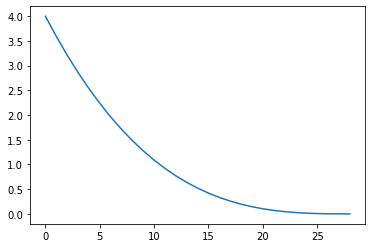

In [7]:
ind = comp.indicator['safety_factor']

sf = ind._safety_factor(
    agd = ind.component.indicator['external_diameter'].perfect,
    czd = ind.component.indicator['external_diameter'].get_condition_profile(200),
    wt = ind.component.indicator['wall_thickness'].get_condition_profile(200),
    margin = 4
)

plt.plot(sf)

In [11]:
df = comp.expected_risk_cost_df(t_end=200)

TypeError: replace expected at least 2 arguments, got 1

In [7]:
dash_id = 'FailureMode-fm-tasks-Task-inspection-active'
#value = False
#fm.update(dash_id, value)

comp.fm['fast_aging'].tasks['inspection'].t_interval=4

In [19]:
import numpy as np 
import math

task = comp.fm['slow_aging'].tasks['inspection']

t_stop = 100
t_delay=10

np.tile(
    np.linspace(5 - 1, 0, 5),
    math.ceil((t_stop - t_delay) / task.t_interval),
)

np.tile(
    np.arange(t_interval -1, 0, -1)
)

NameError: name 't_interval' is not defined

In [20]:
update_cost_fig(comp)

NameError: name 'update_cost_fig' is not defined

In [33]:
schedule = np.tile(
    np.linspace(self.t_interval - 1, 0, self.t_interval),
    math.ceil((t_stop - t_delay) / self.t_interval),
)

NameError: name 'np' is not defined

In [7]:
value = True
sep='-'
dash_id = 'FailureMode-fm-tasks-Task-inspection-active'
value = value / var_to_scale.get(dash_id.split(sep)[-1], 1)


# update the model
pof_obj.update(dash_id, value)
# Simulate an outcome
local = copy.deepcopy(pof_obj)
local.mc_timeline(t_end=200, n_iterations=100)
df = local.expected_risk_cost_df(t_end=200)

fig = px.area(
    df,
    x="time",
    y="cost_cumulative",
    color="task",
    #line_group='failure_mode',
    title="Maintenance Strategy Costs",
)

fig.show()

Invalid ID
100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


In [14]:
dash_id = 'FailureMode-fm-Distribution-untreated-beta'
value = 99
fm.update(dash_id, value)

fm.untreated.gamma

100

In [46]:
dash_id = 'failure_mode-fm'
sep='-'

obj = fm

# Remove the class type and class name from the dash_id
dash_id = dash_id.replace('failure_mode' + sep, '').replace(obj.name + sep, '')
var = dash_id.split(sep)[0]

# Check if the variable is an attribute of the class
if var in obj.__dict__:

    # Check if the variable is a dictionary
    if isinstance(obj.__dict__[var], dict): 
        key = dash_id.split(sep)[1]

        # Check if the variable is a class with its own dash methods
        if isinstance(obj.__dict__[var][key], (Component, Condition, Distribution, Consequence)):
                val = get_dash_id_value(obj.__dict__[var][key], dash_id)
        else:
            val = obj.__dict__[var][key]
    else:
        val = obj.__dict__[var]
else:
    val = ("Invalid id \"%s\" %s not in class" %(dash_id, var))



In [47]:
val

'Invalid id "conditions-wall_thickness" conditions not in class'

In [13]:
local = copy.deepcopy(fm)
local.mc_timeline(t_end=200, n_iterations=100)
df = local.expected_risk_cost_df()

fig = px.area(
    df,
    x="time",
    y="cost_cumulative",
    color="task",
    #line_group='failure_mode',
    title="Maintenance Strategy Costs",
)
fig.show()

100%|██████████| 100/100 [00:01<00:00, 58.39it/s]


In [8]:
df

,time,cost,cost_cumulative
task,,,
inspection,0,0,0
inspection,1,0,0
inspection,2,0,0
inspection,3,0,0
inspection,4,0,0
...,...,...,...
risk,196,0,0
risk,197,0,0
risk,198,0,0


In [9]:
# Testing to find the problem with the 
comp.expected_risk_cost_df(t_end=200).groupby(by=['failure_mode', 'task']).sum()

time  cost  cost_cumulative
failure_mode task                                             
fast_aging   cm                   20100     0                0
             inspection           20100     0                0
             on_condition_repair  20100     0                0
             risk                 20100     0                0
random       cm                   20100     0                0
             inspection           20100     0                0
             on_condition_repair  20100     0                0
             risk                 20100     0                0
slow_aging   cm                   20100     0                0
             inspection           20100     0                0
             on_condition_repair  20100     0                0
             risk                 20100     0                0

In [10]:
for fm in comp.fm.values():
    fm.cof.risk_cost_total = 10000

In [11]:
def update_maintenance_strategy():

    fm.mc_timeline(t_end=200, n_iterations=100)
    df = fm.expected_risk_cost_df()

    fig = px.area(
        df,
        x="time",
        y="cost_cumulative",
        color="task",
        #line_group='failure_mode',
        title="Maintenance Strategy Costs",
    )

    return fig

update_maintenance_strategy().show()

100%|██████████| 100/100 [00:01<00:00, 69.61it/s]


In [12]:
rc = fm.expected_risk_cost()



In [20]:
%%timeit
t_end = 0


40.5 µs ± 8.25 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [11]:
df = comp.expected_risk_cost_df(t_end=200)
df.set_index(['failure_mode', 'task']).loc[['slow_aging', 'inspection']].head(10)

time cost cost_cumulative
failure_mode task                                
slow_aging   inspection    0    0               0
             inspection    1    0               0
             inspection    2    0               0
             inspection    3    0               0
             inspection    4    0               0
             inspection    5    0               0
             inspection    6    0               0
             inspection    7    0               0
             inspection    8    0               0
             inspection    9    0               0

In [8]:
dash_id = 'task-inspection-active'
dash_id = dash_id.replace(next_id + sep, "")
task_name= dash_id.split(sep)[0]
dash_id = dash_id.replace(next_id + sep, "")
dash_id

'inspection-active'

In [13]:
task.active

False